# Nutrient (N, P, Fe) distribution - draft 2

Here I plot the nutrients N, P, and Fe that were simulated by the Darwin global model (Dutkiewicz et al., 2019).

I calculate the nutrient supply ratios phi(P:N) (1) and phi(Fe:N) (2), which are used to describe the excess P and Fe supply. These are the ratio of the gross delivery rate of phosphorus and iron, relative to the gross delivery rate of bioavailable nitrogen, normalized by estimated P:N or Fe:N ratio of nondiazotrophic phytoplankton community (Ward et al., 2013).

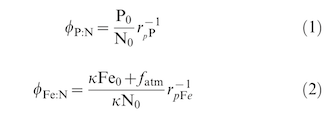

Based Dutkiewicz et al. (2019), I included all nutrient fluxes of dissolved nitrogen, phosphate, or iron to the model surface 100m. In other words, transport terms and remineralization terms.\
Assumptions:

- Integrate over top 100m (= first 6 depth levels of the model)
- Multiply each box with its dz --> get mmol/m2/s
- Multiply with seconds per year --> get mmol/m2/y
- Sum up transport terms and remineralization terms; iron dust deposition is included in Nutr['S_Fe']
- Also show transport and remin terms alone

#### Load requirements and set switches

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
#Load data

# iron dust flux
fein = np.fromfile('/Users/meilers/MITinternship/Data/mahowald2009_solubile_current_smooth_oce_mth-2d.bin', '>f4').reshape(12,160,360)

# model simulation output
Nutr = xr.open_dataset('/Users/meilers/MITinternship/Data/Nutr_tend.0000014400.nc')

grid = xr.open_dataset('/Users/meilers/MITinternship/Data/supply50m.nc')

lon = grid.lon   #needed for plotting
lat = grid.lat    #needed for plotting

In [3]:
# transport terms
NH4 = Nutr['gTr02']
NO2 = Nutr['gTr03']
NO3 = Nutr['gTr04']
PO4 = Nutr['gTr05']
FeT = Nutr['gTr07']

# other terms: remineralization and dust in case of Fe
S_DIN = Nutr['S_DIN']
S_PO4 = Nutr['S_PO4']
S_Fe = Nutr['S_Fe']

#reducing the T dimension (which is 1 anyway)
NH4 = NH4[0,:,:,:]
NO2 = NO2[0,:,:,:]
NO3 = NO3[0,:,:,:]
PO4 = PO4[0,:,:,:]
FeT = FeT[0,:,:,:]

S_DIN = S_DIN[0,:,:,:]
S_PO4 = S_PO4[0,:,:,:]
S_Fe = S_Fe[0,:,:,:]

# define constants and dz
sec = 31557600  #seconds per year (365.25*86400)
dz = [10,10,15,20,20,25] #,35,50,75,100] #(...) dz between two depth layers

Sum nutrients up over depth and multiply with corresponding dz and sec

In [4]:
NH4_int = np.zeros((6,160,360))
for i in range(len(dz)):
    NH4_int[i,:,:] = NH4[i,:,:]*dz[i]*sec
    print(np.max(NH4_int[i,:,:]))
    print(i)
NH4_int = np.sum(NH4_int,axis=0)

NO2_int = np.zeros((6,160,360))
for i in range(len(dz)):
    NO2_int[i,:,:] = NO2[i,:,:]*dz[i]*sec    
NO2_int = np.sum(NO2_int,axis=0)
 
NO3_int = np.zeros((6,160,360))
for i in range(len(dz)):
    NO3_int[i,:,:] = NO3[i,:,:]*dz[i]*sec    
NO3_int = np.sum(NO3_int,axis=0)

PO4_int = np.zeros((6,160,360))
for i in range(len(dz)):
    PO4_int[i,:,:] = PO4[i,:,:]*dz[i]*sec    
PO4_int = np.sum(PO4_int,axis=0)

FeT_int = np.zeros((6,160,360))
for i in range(len(dz)):
    FeT_int[i,:,:] = FeT[i,:,:]*dz[i]*sec    
FeT_int = np.sum(FeT_int,axis=0)

S_DIN_int = np.zeros((6,160,360))
for i in range(len(dz)):
    S_DIN_int[i,:,:] = S_DIN[i,:,:]*dz[i]*sec    
S_DIN_int = np.sum(S_DIN_int,axis=0)

S_PO4_int = np.zeros((6,160,360))
for i in range(len(dz)):
    S_PO4_int[i,:,:] = S_PO4[i,:,:]*dz[i]*sec    
S_PO4_int = np.sum(S_PO4_int,axis=0)

S_Fe_int = np.zeros((6,160,360))
for i in range(len(dz)):
    S_Fe_int[i,:,:] = S_Fe[i,:,:]*dz[i]*sec    
S_Fe_int = np.sum(S_Fe_int,axis=0)

263.1270118530665
0
107.67586800047866
1
228.76165116540506
2
913.2008705288172
3
564.3217592180008
4
766.334185670712
5


Add up the different N species

In [5]:
N_int = NH4_int + NO3_int + NO2_int
N_int_o = S_DIN_int

(The next step is actually not necessary. It's a relict from the coding process and now just allows to rename the varialbes.)

In [6]:
from copy import deepcopy
N_trans = deepcopy(N_int)
P_trans = deepcopy(PO4_int)
Fe_trans = deepcopy(FeT_int)
N_remin = deepcopy(N_int_o)
P_remin = deepcopy(S_PO4_int)
Fe_other = deepcopy(S_Fe_int)

Define transport, remineralization and nutrient fluxes; add iron flux

In [7]:
f_dust = np.sum(fein,axis=0)*sec # only needed to calculate the Fe remineraliztion
                                 # Fe_other contains dust. If we need Fe remin only: subtract dust
Fe_remin = Fe_other-f_dust

N_tot = np.add(N_trans,N_remin)
P_tot = np.add(P_trans,P_remin)
Fe_tot = np.add(Fe_trans,Fe_other)#,f_dust) #including dust

Reminder: now we have the following variables: 
- N_tot, P_tot, Fe_tot
- N_trans, P_trans, Fe_trans 
- N_remin, P_remin, Fe_remin

Calculate ratios:

In [8]:
# Bioavailable nutrient supply --> bio_PN, bio_FeN
# Constants
rpP = 0.0625
rpFe = 6.25e-5
k = 0.1

bio_PN_tot = (np.divide(P_tot,N_tot))*(1/rpP)
bio_FeN_tot = (np.divide(Fe_tot,N_tot))*(1/rpFe)

bio_PN_trans = (np.divide(P_trans,N_trans))*(1/rpP)
F = np.add((Fe_trans*k),f_dust*100)
bio_FeN_trans = (np.divide(F,(N_trans*k)))*(1/rpFe)

bio_PN_remin = (np.divide(P_remin,N_remin))*(1/rpP)
bio_FeN_remin = (np.divide(Fe_remin,N_remin))*(1/rpFe)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encou

Plot the nutrient ratios:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linstyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


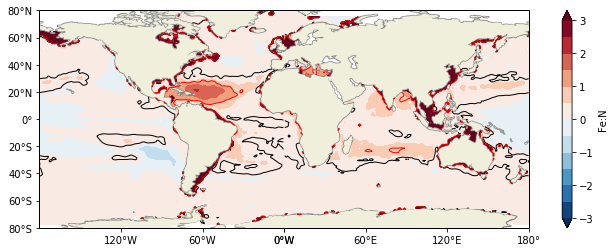

In [9]:
nu = 1   #chose nutrient here: 0=Fe, 1=N, 2=P
nutr = [bio_PN_tot,bio_FeN_tot,bio_PN_trans,bio_FeN_trans,bio_PN_remin,bio_FeN_remin]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N','transport P:N','transport Fe:N','remin P:N','remin Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN,levs_PN,levs_FeN,levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(12,4))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon,lat,np.log(nutr[nu]),levels=levs[nu],cmap=colmap,extend='both')
con1 = ax.contour(lon,lat,nutr[nu],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
con2 = ax.contour(lon,lat,nutr[nu],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nu])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/darfts_trans_NO3_fixed.png', bbox_inches='tight', dpi=300)


Compare to Ward et al., 2013:

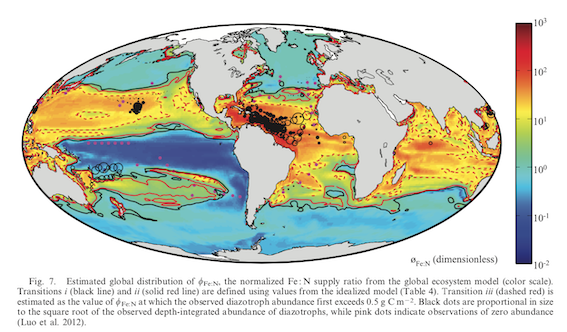

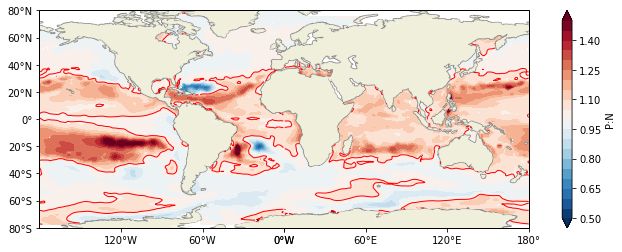

In [10]:
nut = 0    
nutrient = [bio_PN_tot,bio_PN_trans,bio_PN_remin]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','transport P:N','remin P:N']

levs_PN = np.linspace(0.5,1.5,21)
colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(12,4))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon,lat,nutrient[nut],levels=levs_PN,cmap=colmap,extend='both')
#con1 = ax.contour(lon,lat,nutrient[nut],levels=[0.99],colors='purple',linewidths=1,linstyle='solid')
con2 = ax.contour(lon,lat,nutrient[nut],levels=[1.04],colors='r',linewidths=1,linstyle='solid')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'_104.png', bbox_inches='tight', dpi=300)

Compare to Ward et al., 2013:

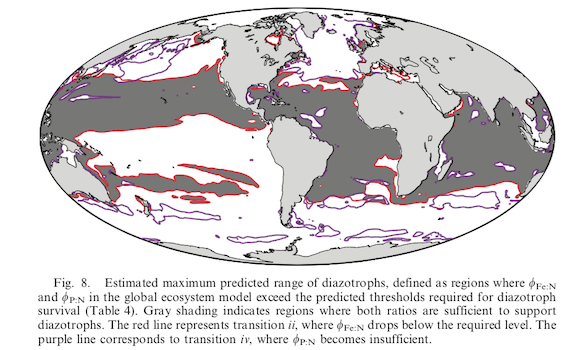

### Import diazotroph observational data

NameError: name 'lon1' is not defined

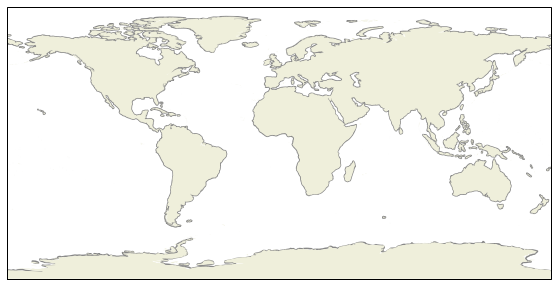

In [12]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN_tot,bio_FeN_tot]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'.png', bbox_inches='tight', dpi=300)

In [ ]:
# Load diazotroph data
ds = Dataset('/Users/meilers/MITinternship/Data/MarEDat20130403Diazotrophs.nc', 'r')

# extract variables which are needed and convert/integrate
lon = ds.variables['LONGITUDE']
lat = ds.variables['LATITUDE']
#lon_new = lon[:] #in case I needed to modify the lon/lat to match it the lon/lat of the nutrients
#lat_new = lat[:]

obs = ds.variables['OBSERVATIONS']
abund = ds.variables['ABUNDANCE']

obs_int = np.sum(obs[:,0:6,:,:],axis=1)
abund_int = np.sum(abund[:,0:6,:,:],axis=1)

obs_tot = np.sum(obs_int,axis=0)
abund_tot = np.sum(abund_int,axis=0)

In [ ]:
# Create a mask: 0 = absence, 1 = presence
        
mask1 = np.zeros_like(obs_tot)
mask1[obs_tot>0] = 1

mask2 = np.zeros_like(abund_tot)
mask2[abund_tot>0] = 1

find1 = np.where(mask1==1)
find2 = np.where(mask2==1)

plt.plot(find1[1],find1[0],'.',color='b')
plt.plot(find2[1],find2[0],'.',color='r')
plt.show()

In [ ]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN,bio_FeN]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
#c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
#con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
#con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
plt.plot(lon[find1[1]],lat[find1[0]],'.',color='b',label='obs')
plt.plot(lon[find2[1]],lat[find2[0]],'.',color='g',label='abund')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()

In [ ]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN,bio_FeN]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
plt.plot(lon[find1[1]],lat[find1[0]],'.',color='b') #blue = observations
plt.plot(lon[find2[1]],lat[find2[0]],'.',color='g') #green = abundance
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()